In [1]:
from dask.distributed import Client, progress
dask_client = Client(threads_per_worker=10, n_workers=4)
dask_client

Client Scheduler: tcp://127.0.0.1:46671 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 40 Memory: 99.69 GB


In [308]:
dask_client.shutdown()


In [2]:
import dask_image.imread
import dask_image.ndfilters
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import dask
from skimage.io import imsave, imread
import dask
import dask.array as da
from scipy.signal import convolve2d
from skimage.feature import peak_local_max
from pathlib import Path
from PIL import Image
import matplotlib.patches as patches

In [3]:
def da_imsave(fnames, arr, compute=False):
    """Write arr to a stack of images assuming
    the last two dimensions of arr as image dimensions.
    
    Parameters
    ----------
    fnames: string
        A formatting string like 'myfile{:02d}.png'
        Should support arr.ndims-2 indices to be formatted
    arr: dask.array
        Array of at least 2 dimensions to be written to disk as images
    compute: Boolean (optional)
        whether to write to disk immediately or return a dask.array of the to be written indices
    
    """
    indices = [da.arange(n, chunks=c) for n,c in zip(arr.shape[:-2], arr.chunksize[:-2])]
    index_array = da.stack(da.meshgrid(*indices,indexing='ij'), axis=-1).rechunk({-1:-1})

    @da.as_gufunc(signature=f"(i,j),({arr.ndim-2})->({arr.ndim-2})", output_dtypes=int, vectorize=True)
    def saveimg(image, index):
        im = Image.fromarray(image.squeeze().astype(np.uint32))
        im.save(fnames.format(*index))
        return index
    
    res = saveimg(arr,index_array)
    if compute == True:
        res.compute()
    else:
        return res

In [4]:
@da.as_gufunc(signature=f"(i,j),(),(),()->(i,j)", output_dtypes=int, vectorize=True, allow_rechunk=True)
def max_of_clusters_var_cl_th_dis(img, cl, th, dis):
    mask = np.ones([cl,cl])
    clusters_scipy = convolve2d(img, mask, mode='same', fillvalue=0)
    maxima = peak_local_max(clusters_scipy, min_distance=dis, threshold_abs=th)
    max_value_mask = np.zeros([400,400])
    max_value_mask[maxima[:,0], maxima[:,1]] = 1
    max_clusts = clusters_scipy * max_value_mask
    return max_clusts

In [5]:
@da.as_gufunc(signature=f"(i,j),(),(),()->(i,j)", output_dtypes=int, vectorize=True, allow_rechunk=True)
def single_photon_mask_var_cl_th_dis(img, cl, th, dis):
    mask = np.ones([cl,cl])
    clusters_scipy = convolve2d(img, mask, mode='same', fillvalue=0)
    maxima = peak_local_max(clusters_scipy, min_distance=dis, threshold_abs=th)
    max_value_mask = np.zeros([400,400])
    max_value_mask[maxima[:,0], maxima[:,1]] = 1
    return max_value_mask

In [6]:
@da.as_gufunc(signature=f"(i,j),(),()->(i,j)", output_dtypes=int, vectorize=True)
def max_of_clusters_var_cl_th_counts(img, cl, th):
    mask = np.ones([cl,cl])
    clusters_scipy = convolve2d(img, mask, mode='same', fillvalue=0)
    maxima = peak_local_max(clusters_scipy, min_distance=cl, threshold_abs=th)
    max_value_mask = np.zeros([400,400])
    max_value_mask[maxima[:,0], maxima[:,1]] = 1
    max_clusts = clusters_scipy * max_value_mask
    counts = max_value_mask.sum(axis=(0,1))
    return max_clusts

In [7]:
@da.as_gufunc(signature=f"(i,j),(),()->()", output_dtypes=int, vectorize=True)
def cluster_counts_cl_th(img, cl, th):
    mask = np.ones([cl,cl])
    clusters_scipy = convolve2d(img, mask, mode='same', fillvalue=0)
    maxima = peak_local_max(clusters_scipy, min_distance=cl, threshold_abs=th)
    return len(maxima)

# Loading pedestals

In [8]:
init_dark = r'/mnt/nvme_ssd/220304_captures/220304_run_d0_f0_14[4-5]_*'
dark_images = dask_image.imread.imread(init_dark, arraytype="numpy")
not_null_dark = dark_images[dark_images.sum(axis=(1,2)) != 0]
avg_dark_old = np.average(not_null_dark, axis=0)

In [10]:
dark_avg_old_comptured = avg_dark_old.compute() # init dark capture from static 10000 frames

In [37]:
imsave("dark_avg_old.tiff", dark_avg_old_comptured)

# Loading pre-calculated pedestal

In [134]:
dark_avg_old_comptured = imread("dark_avg_old.tiff")

# Loading captures

In [135]:
filename_pattern = r'/mnt/nvme_ssd/220304_captures/147_200/*'
images_old = dask_image.imread.imread(filename_pattern, arraytype="numpy")

In [136]:
images_minus_dark_old = images_old - dark_avg_old_comptured
images_minus_dark_old_shortend = images_minus_dark_old[:26000]

# Fitting noise

In [14]:
dark_minus_ped = dark_images - avg_dark_old

In [27]:
dark_minus_ped.shape

(9973, 400, 400)

In [15]:
bins_noise = np.arange(-100, 100)

In [16]:
noise_hist, b = da.histogram(dark_minus_ped.flatten(), bins_noise)

In [ ]:
noise_hist_comp = noise_hist.compute()

In [17]:
import lmfit
from lmfit.models import GaussianModel

In [ ]:
mod = GaussianModel()
x = np.arange(-100, 99)
params = mod.guess(noise_hist_comp/26000, x=x)
result = mod.fit(data=noise_hist_comp/26000, params=params, x=x)
print(result.fit_report())

In [18]:
noise_sim_26000 = da.random.normal(loc=-0.5, scale=19.94, size=(26000,400,400))
noise_hist_sim, b = da.histogram(noise_sim_26000.flatten(), bins_noise)

In [ ]:
noise_hist_sim_comp = noise_hist_sim.compute()

In [ ]:
%matplotlib notebook
plt.plot(x, noise_hist_comp/10000, )
#plt.plot(x, result.best_fit*26000, label='gaus fit')
plt.plot(x, noise_hist_sim_comp/26000, label='simulated noise')
plt.legend()

# Evaluation of captures

## Dark evaluation ring search

In [244]:
init_dark = r'/mnt/nvme_ssd/220304_captures/220304_run_d0_f0_14[4-5]_*'
dark_images = dask_image.imread.imread(init_dark, arraytype="numpy")
dark_images_minus_avg = dark_images - dark_avg_old_comptured

In [273]:
THRESHOLD = 150

In [288]:
th_mask =  dark_images_minus_avg[:1000] > THRESHOLD # boolean mask for each frame
images_th_masked = th_mask # apply mask

In [289]:
sum_th_images = images_th_masked.sum(axis=0)

In [290]:
sum_th_images_comp = sum_th_images.compute()

<IPython.core.display.Javascript object>


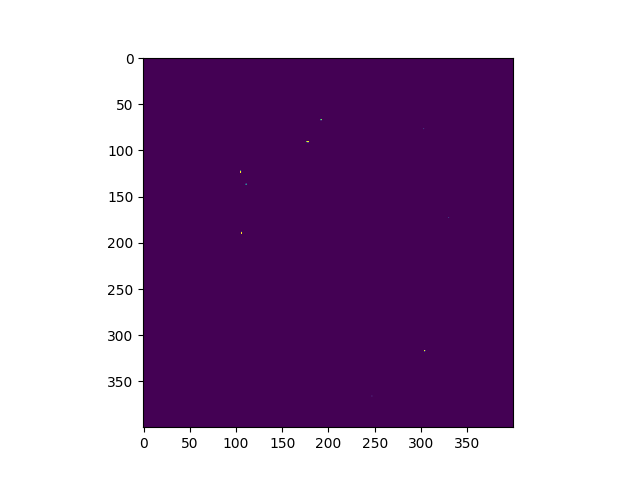

In [291]:
%matplotlib notebook
plt.imshow(sum_th_images_comp, vmax=5)

In [292]:
im = Image.fromarray(sum_th_images_comp.astype(np.uint32))
im.save("220430_pictures/noist_th_150/noise_th_150_1000.tiff")


### 2x2

#### Mask only (assume all pixels are single pixels

In [303]:
dark_clustered_2x2 = single_photon_mask_var_cl_th_dis(dark_images_minus_avg[:1000], 2, 200, 1)

In [304]:
sum_dark_clustered_2x2 = dark_clustered_2x2.sum(axis=0)

In [305]:
sum_dark_clustered_2x2_comp = sum_dark_clustered_2x2.compute()

<IPython.core.display.Javascript object>


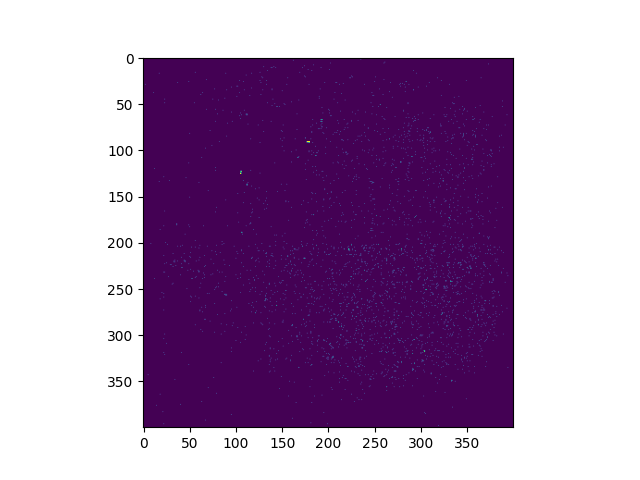

In [306]:
%matplotlib notebook
plt.imshow(sum_dark_clustered_2x2_comp, vmax=5)

In [307]:
im = Image.fromarray(sum_dark_clustered_2x2_comp.astype(np.uint32))
im.save("220430_pictures/noise_cl_2_th_200/single_count_mask_cl_2_th_200_sum_1000.tiff")


## Ring evaluation

In [42]:
images_minus_dark_old.shape

(101970, 400, 400)

### No filter

In [108]:
images_minus_dark_old_short = images_minus_dark_old[:50000]

In [109]:
sum_images = images_minus_dark_old_short.sum(axis=0)

In [110]:
sum_images_comp = sum_images.compute()

<IPython.core.display.Javascript object>


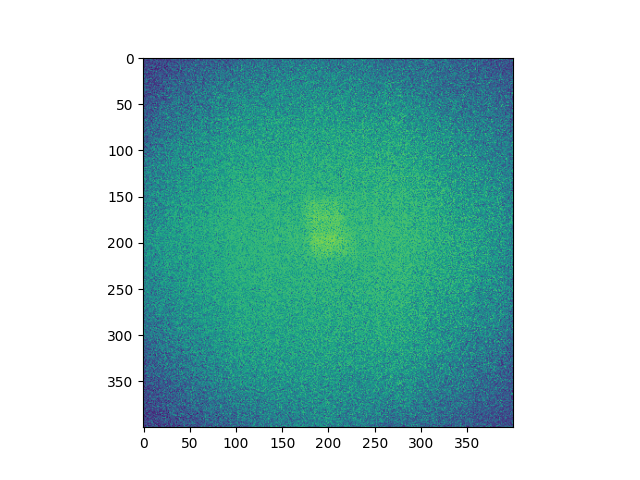

In [111]:
%matplotlib notebook
plt.imshow(sum_images_comp)

In [112]:
im = Image.fromarray(sum_images_comp.astype(np.uint32))
im.save("220430_pictures/no_filter/no_filter_sum_50000.tiff")


### Thresholding

In [12]:
THRESHOLD = 180

In [13]:
images_minus_dark_old_short = images_minus_dark_old[:50000]

In [14]:
th_mask = images_minus_dark_old_short > THRESHOLD # boolean mask for each frame
images_th_masked = th_mask # apply mask

In [15]:
sum_th_images = images_th_masked.sum(axis=0)

In [ ]:
sum_th_images_comp = sum_th_images.compute()

distributed.utils - ERROR - 'start'
Traceback (most recent call last):
  File "/home/moench/.local/lib/python3.6/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home/moench/.local/lib/python3.6/site-packages/distributed/dashboard/components/shared.py", line 312, in update
    ts = metadata["keys"][self.key]
KeyError: 'start'
tornado.application - ERROR - Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <zmq.eventloop.ioloop.ZMQIOLoop object at 0x7ffb584a9e80>>, <Task finished coro=<_needs_document_lock.<locals>._needs_document_lock_wrapper() done, defined at /home/moench/.local/lib/python3.6/site-packages/bokeh/server/session.py:51> exception=KeyError('start',)>)
Traceback (most recent call last):
  File "/home/moench/.local/lib/python3.6/site-packages/tornado/ioloop.py", line 741, in _run_callback
    ret = callback()
  File "/home/moench/.local/lib/python3.6/site-packages/tornado/ioloop.py", line 765, in _discard_f

<IPython.core.display.Javascript object>


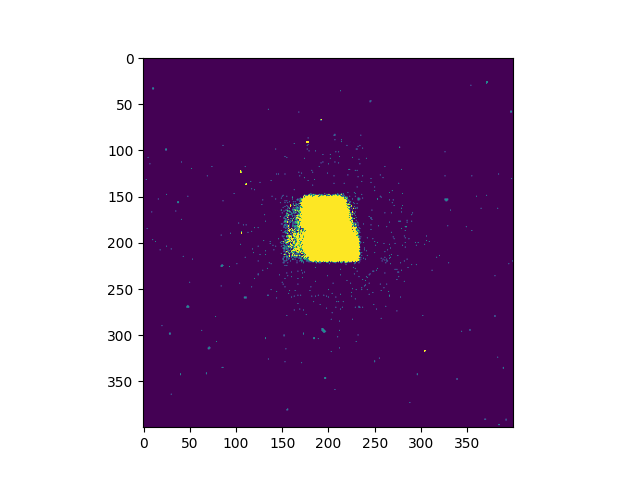

In [220]:
%matplotlib notebook
plt.imshow(sum_th_images_comp, vmax=2)

In [221]:
im = Image.fromarray(sum_th_images_comp.astype(np.uint32))
im.save("220430_pictures/th_180/single_count_mask_only_th_180_sum_20000.tiff")


### partial sums save

In [151]:
partial_sums_th_150 = images_th_masked.cumsum(axis=0)

In [152]:
filename = '/mnt/nvme_ssd/partialsums_th_150/partial_sum_th_150_50000_{:d}.tiff'
da_imsave(filename, partial_sums_th_150, compute=True)

### Clusterisation + thresholding

In [51]:
CL_THRESHOLD_2x2 = 200 # 2*sigma*5 = 200
CL_THRESHOLD_3x3 = 200 # 3*sigma*5 = 300?


### 2x2

#### Mask only (assume all pixels are single pixels

In [263]:
single_photons_clustered_2x2 = single_photon_mask_var_cl_th_dis(images_minus_dark_old[:2000], 2, 180, 1)

In [264]:
sum_single_photons_clustered_2x2 = single_photons_clustered_2x2.sum(axis=0)

In [265]:
sum_single_photons_clustered_2x2_comp = sum_single_photons_clustered_2x2.compute()

<IPython.core.display.Javascript object>


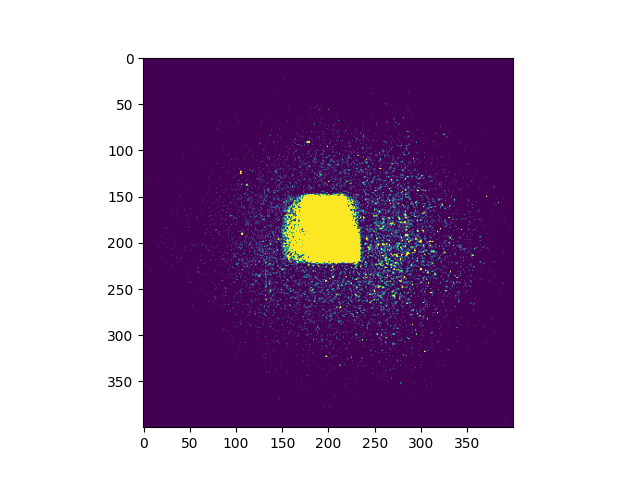

In [266]:
%matplotlib notebook
plt.imshow(sum_single_photons_clustered_2x2_comp, vmax=5)

In [82]:
im = Image.fromarray(sum_single_photons_clustered_2x2_comp.astype(np.uint32))
im.save("220430_pictures/cl_2_th_200/single_count_mask_cl_2_th_200_sum_50000.tiff")


### 3x3

#### Mask only (assume all pixels are single pixels

In [240]:
single_photons_clustered_3x3 = single_photon_mask_var_cl_th_dis(images_minus_dark_old[:10000], 3, 200, 2)

In [241]:
sum_single_photons_clustered_3x3 = single_photons_clustered_3x3.sum(axis=0)

In [242]:
sum_single_photons_clustered_3x3_comp = sum_single_photons_clustered_3x3.compute()

<IPython.core.display.Javascript object>


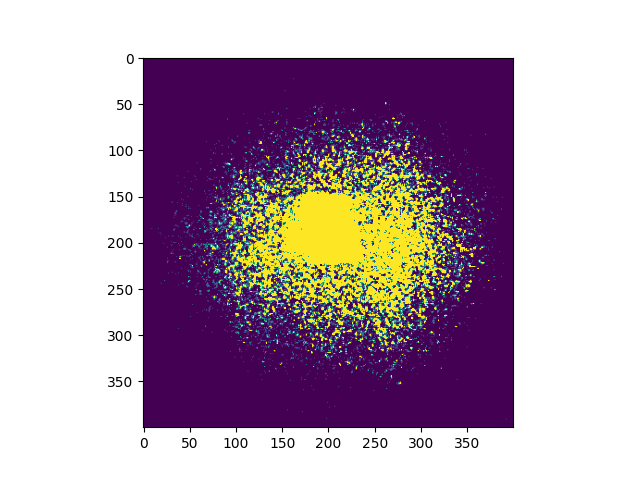

In [238]:
%matplotlib notebook
plt.imshow(sum_single_photons_clustered_3x3_comp, vmax=5)

In [243]:
im = Image.fromarray(sum_single_photons_clustered_3x3_comp.astype(np.uint32))
im.save("220430_pictures/cl_3_th_200/single_count_mask_cl_3_th_200_sum_10000.tiff")


### partial sums save

In [147]:
partial_sums_cl_2 = single_photons_clustered_2x2.cumsum(axis=0)

In [148]:
filename = '/mnt/nvme_ssd/partialsums/partial_sum_cl2_th_180_50000_{:d}.tiff'
da_imsave(filename, partial_sums_cl_2, compute=True)

## Histograms

In [137]:
bins = np.arange(-200, 1000)

In [138]:
init_dark = r'/mnt/nvme_ssd/220304_captures/220304_run_d0_f0_14[4-5]_*'
dark_images = dask_image.imread.imread(init_dark, arraytype="numpy")
dark_images_minus_avg = dark_images - dark_avg_old_comptured

Limiting images amount to 9700

In [116]:
dark_images_minus_avg.shape

(9973, 400, 400)

In [163]:
dark_images_minus_dark_old = dark_images_minus_avg[:9700]
dark_images_cl_2x2_old = max_of_clusters_var_cl_th_dis(dark_images_minus_avg[:9700], 2, -250, 1)
dark_images_cl_3x3_old = max_of_clusters_var_cl_th_dis(dark_images_minus_avg[:9700], 3, -250, 2)


images_minus_dark_old_no_filter = images_minus_dark_old[:9700]
images_cl_2x2_old = max_of_clusters_var_cl_th_dis(images_minus_dark_old[:9700], 2, -250, 1)
images_cl_3x3_old = max_of_clusters_var_cl_th_dis(images_minus_dark_old[:9700], 3, -250, 2)

In [164]:
dark_images_minus_dark_old_hist, _ = da.histogram(dark_images_minus_dark_old.flatten(), bins)
dark_images_cl_2x2_old_hist, _ = da.histogram(dark_images_cl_2x2_old.flatten(), bins)
dark_images_cl_3x3_old_hist, _ = da.histogram(dark_images_cl_3x3_old.flatten(), bins)


images_minus_dark_old_no_filter_hist, _ = da.histogram(images_minus_dark_old_no_filter.flatten(), bins)
images_cl_2x2_dark_old_hist, _ = da.histogram(images_cl_2x2_old.flatten(), bins)
images_cl_3x3_dark_old_hist, _ = da.histogram(images_cl_3x3_old.flatten(), bins)

In [165]:
dark_images_minus_dark_old_hist_comp = dark_images_minus_dark_old_hist.compute()

In [166]:
dark_images_cl_2x2_old_hist_comp = dark_images_cl_2x2_old_hist.compute()

In [167]:
dark_images_cl_3x3_old_hist_comp = dark_images_cl_3x3_old_hist.compute()

In [168]:
images_minus_dark_old_no_filter_hist_comp = images_minus_dark_old_no_filter_hist.compute()

In [169]:
images_cl_2x2_dark_old_hist_comp = images_cl_2x2_dark_old_hist.compute()

In [170]:
images_cl_3x3_dark_old_hist_comp = images_cl_3x3_dark_old_hist.compute()

<IPython.core.display.Javascript object>


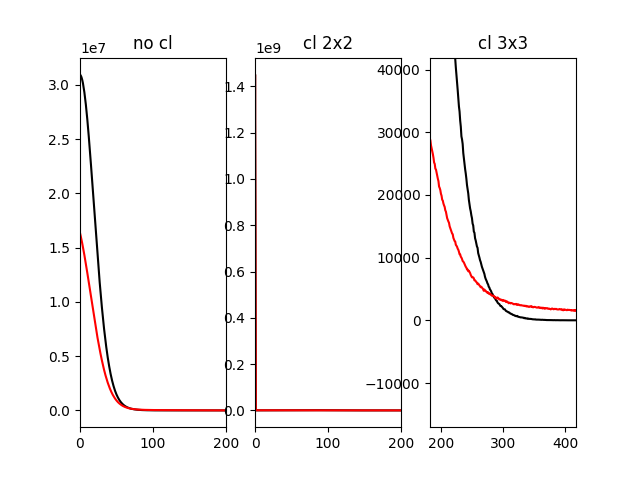

In [172]:
%matplotlib notebook
plot_x = np.arange(-200, 999)
plt.subplot(1,3,1)
plt.xlim(0, 200)
plt.title('no cl')
plt.plot(plot_x, dark_images_minus_dark_old_hist_comp,color = 'black', label ='noise no cl')
plt.plot(plot_x, images_minus_dark_old_no_filter_hist_comp, color= 'red', label = 'signal no cl')

plt.subplot(1,3,2)
plt.xlim(0, 200)
plt.title('cl 2x2')
plt.plot(plot_x, dark_images_cl_2x2_old_hist_comp, color= 'black', label ='noise cl 2x2')
plt.plot(plot_x, images_cl_2x2_dark_old_hist_comp, color= 'red', label = 'signal cl 2x2')

plt.subplot(1,3,3)
plt.title('cl 3x3')
plt.xlim(0, 300)
plt.plot(plot_x, dark_images_cl_3x3_old_hist_comp, color= 'black', label ='noise cl 3x3')

plt.plot(plot_x, images_cl_3x3_dark_old_hist_comp, color= 'red' ,label = 'signal cl 3x3')
#plt.legend()

In [173]:
np.savetxt('noise_hist.csv',
           np.column_stack((plot_x,
                            dark_images_minus_dark_old_hist_comp,
                            dark_images_cl_2x2_old_hist_comp,
                            dark_images_cl_3x3_old_hist_comp)),
           header="hist bins, noise, noise 2x2 cl, noise 3x3 cl",
           delimiter=",")

In [174]:
np.savetxt('signal_hist.csv',
           np.column_stack((plot_x,
                            images_minus_dark_old_no_filter_hist_comp,
                            images_cl_2x2_dark_old_hist_comp,
                            images_cl_3x3_dark_old_hist_comp)),
           header="hist bins, signal, signal 2x2 cl, signal 3x3 cl",
           delimiter=",")

### Simple thresholding with 150

In [ ]:
pixels_filtered_ring = images_minus_dark_old > 150 # boolean mask for each frame
single_shots_ring_th = pixels_filtered_ring * images_minus_dark_old # apply mask

In [ ]:
bins = np.arange(140, 300)

In [ ]:
histogram, bins = da.histogram(single_shots_ring_th.flatten(), bins)

In [ ]:
histogram_comp = histogram.compute()

In [ ]:
%matplotlib notebook

plt.plot(np.arange(140, 299), histogram_comp)


assume that there are only 1 photon in each point than we can count the lower estimations by summation of boolean mask (ones) in each frame

In [ ]:
th_counts_in_shot_ring = pixels_filtered_ring.sum(axis=(1,2))

In [ ]:
th_counts_in_shot_ring_comp = th_counts_in_shot_ring.compute()

In [ ]:
print(f'th counts mean {np.average(th_counts_in_shot_ring_comp)} with std dev {np.std(th_counts_in_shot_ring_comp)}')

In [ ]:
%matplotlib notebook
plt.hist(th_counts_in_shot_ring_comp, bins=range(0,70))
plt.title('single shot counts histogram, >150 threshold applied')
plt.xlabel('stray image shot counts')
print(f"average counts: {np.average(th_counts_in_shot_ring_comp)}")

### Clustering 2x2 & max search with

In [28]:
clustered2x2 = max_of_clusters_var_cl_th(images_minus_dark_old[:9973], 2, None)

In [29]:
clustered2x2_noise_sim = max_of_clusters_var_cl_th(noise_sim_26000[:9973], 2, None)

In [30]:
clustered2x2_noise_real = max_of_clusters_var_cl_th(dark_minus_ped, 2, None)

In [31]:
bins_cl2x2 = np.arange(-40, 1000)

In [32]:
histogram_cl2x2, bins = da.histogram(clustered2x2.flatten(), bins_cl2x2)
hist_clustered2x2_noise_sim, _ = da.histogram(clustered2x2_noise_sim.flatten(), bins_cl2x2)
clustered2x2_noise_real, _ = da.histogram(clustered2x2_noise_real.flatten(), bins_cl2x2)

In [33]:
histogram_cl2x2_comp = histogram_cl2x2.compute()

In [34]:
hist_clustered2x2_noise_sim_comp = hist_clustered2x2_noise_sim.compute()

In [35]:
hist_clustered2x2_noise_real_comp = clustered2x2_noise_real.compute()

<IPython.core.display.Javascript object>


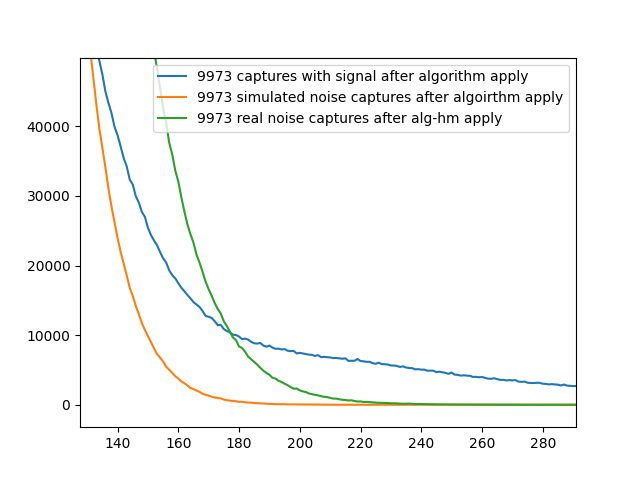

In [36]:
%matplotlib notebook
plt.plot(range(-40,999), histogram_cl2x2_comp, label = '9973 captures with signal after algorithm apply')
plt.plot(range(-40, 999), hist_clustered2x2_noise_sim_comp, label = '9973 simulated noise captures after algoirthm apply')
plt.plot(range(-40, 999), hist_clustered2x2_noise_real_comp, label = '9973 real noise captures after alg-hm apply')
plt.legend()

In [ ]:
counts_comp = counts.compute()

In [ ]:
%matplotlib notebook
plt.hist(counts_comp, bins=range(0,100))
plt.title('single shot counts histogram, 2x2 clustering applied')
plt.xlabel('stray shot counts')
print(f"average counts {np.average(counts_comp)}")

In [ ]:
clustered2x2_sum = clustered2x2.sum(axis=0)

In [ ]:
clustered2x2_sum_comp = clustered2x2_sum.compute()

In [ ]:
%matplotlib notebook
plt.imshow(clustered2x2_sum_comp, vmax=500)


### Clustering 3x3 & max search with

In [ ]:
clustered3x3 = max_of_clusters_var_cl_th(images_minus_dark_old, 3, 1)

In [ ]:
bins_cl3x3 = np.arange(1, 1000)

In [ ]:
histogram_cl3x3, bins = da.histogram(clustered3x3.flatten(), bins_cl3x3)

In [ ]:
histogram_cl3x3_comp = histogram_cl3x3.compute()

In [ ]:
%matplotlib notebook
plt.plot(range(1,999), histogram_no_proc_comp, label = "no processing")
plt.plot(range(1,999), histogram_cl2x2_comp, label="2x2 clustering")
plt.plot(range(1,999), histogram_cl3x3_comp, label="3x3 clustering")
#plt.yscale('log')
plt.axvline(150, linestyle='--', color='red', label='threshold = 150')
plt.axvline(180, linestyle='--', color='pink', label='expectedGd M5\nphoton ADU = 180')
plt.axvline(200, linestyle='--', color='black', label='MÖNCH software\nhardcoded threshold $2\cdot 5\sigma = 200$')

#plt.ylim(0,8.5e5)
plt.xlabel('Pixel/Cluster value in ADU')
plt.legend()

In [ ]:
counts_comp = counts.compute()

In [ ]:
%matplotlib notebook
plt.hist(counts_comp, bins=range(0,100))
plt.title('single shot counts histogram, 2x2 clustering applied')
plt.xlabel('stray shot counts')
print(f"average counts {np.average(counts_comp)}")

In [ ]:
clustered2x2_sum = clustered2x2.sum(axis=0)

In [ ]:
clustered2x2_sum_comp = clustered2x2_sum.compute()

In [ ]:
%matplotlib notebook
plt.imshow(clustered2x2_sum_comp, vmax=500)


# Process dark images (1st time)

In [ ]:
dark_path = r'/mnt/nvme_ssd/220307_post_proc/220307_captures/peds/28[1-2]/*'
dark_images = dask_image.imread.imread(dark_path, arraytype="numpy")
print(dark_images.shape)
avg_dark = np.average(dark_images, axis=0)

In [ ]:
dark_avg_comptured = avg_dark.compute() # init dark capture from static 10000 frames

In [ ]:
imsave('misc/avg_dark_capture_10000.tiff', dark_avg_comptured)

# Load pedestal image

In [ ]:
dark_avg_comptured = imread('misc/avg_dark_capture_10000.tiff')

# Captures processing

## Load butterfly

In [ ]:
file_path_butterfly = r'/mnt/nvme_ssd/220307_post_proc/butterfly_only/*/*'
single_shots_butterfly = dask_image.imread.imread(file_path_butterfly, arraytype="numpy")

In [ ]:
print(single_shots_butterfly.shape)

In [ ]:
single_shots_butterfly_no_background = single_shots_butterfly - dark_avg_comptured

### Simple thresholding with 150

In [ ]:
pixels_filtered = single_shots_butterfly_no_background > 150 # boolean mask for each frame
single_shots_butterfly_th = pixels_filtered * single_shots_butterfly_no_background # apply mask

In [ ]:
bins = np.arange(140, 300)

In [ ]:
histogram, bins = da.histogram(single_shots_butterfly_th.flatten(), bins)

In [ ]:
histogram_comp = histogram.compute()

In [ ]:
%matplotlib inline

plt.title('th > 150 for butterfly pixels')
plt.plot(np.arange(140, 299), histogram_comp)


assume that there are only 1 photon in each point than we can count the lower estimations by summation of boolean mask (ones) in each frame

In [ ]:
th_counts_in_shot = pixels_filtered.sum(axis=(1,2))

In [ ]:
th_counts_in_shot_comp = th_counts_in_shot.compute()

In [ ]:
print(f'th counts mean {np.average(th_counts_in_shot_comp)} with std dev {np.std(th_counts_in_shot_comp)}')

In [ ]:
%matplotlib inline
plt.hist(th_counts_in_shot_comp, bins=range(1000,6000,3))
plt.title('single shot counts histogram, >150ADU filter applied')
plt.xlabel('butterfly shot counts')

### Clustering 2x2 & max search 

In [ ]:
clustered2x2 = max_of_clusters_var_cl_th(single_shots_butterfly_no_background, 2,0)

In [ ]:
bins_cl2x2 = np.arange(1, 1000)

In [ ]:
histogram_cl2x2, bins = da.histogram(clustered2x2.flatten(), bins_cl2x2)

In [ ]:
histogram_cl2x2_comp = histogram_cl2x2.compute()

In [ ]:
%matplotlib notebook
plt.plot(range(1,999), histogram_cl2x2_comp)
plt.title('2x2 clustering for for butterfly pixels')



### Check intensity per each frame

In [ ]:
clust2x2_counts_butterfly = cluster_counts_cl_th(single_shots_butterfly_no_background, 2, 110)

In [ ]:
clust2x2_counts_butterfly_comp = clust2x2_counts_butterfly.compute()

In [ ]:
print(clust2x2_counts_butterfly_comp.shape)

In [ ]:
print(f'th counts mean {np.average(clust2x2_counts_butterfly_comp)} with std dev {np.std(clust2x2_counts_butterfly_comp)}')

In [ ]:
%matplotlib inline
plt.hist(clust2x2_counts_butterfly_comp, bins=range(2000,4000))
plt.title('single shot counts histogram, 2x2 clustering applied')
plt.xlabel('butterfly shot counts')

## Load stray pattern

In [ ]:
file_path_ring = r'/mnt/nvme_ssd/220307_post_proc/220307_captures/resonant_captures/*/*'
single_shots_ring = dask_image.imread.imread(file_path_ring, arraytype="numpy")

In [ ]:
single_shots_ring_no_background = single_shots_ring - dark_avg_comptured

In [ ]:
single_shots_ring = single_shots_ring[:26000]
single_shots_ring_no_background = single_shots_ring_no_background[:26000]

### Simple thresholding with 150

In [ ]:
pixels_filtered_ring = single_shots_ring > 150 # boolean mask for each frame
single_shots_ring_th = pixels_filtered_ring * single_shots_ring_no_background # apply mask

In [ ]:
bins = np.arange(140, 300)

In [ ]:
histogram, bins = da.histogram(single_shots_ring_th.flatten(), bins)

In [ ]:
histogram_comp = histogram.compute()

In [ ]:
%matplotlib notebook

plt.plot(np.arange(140, 299), histogram_comp)


assume that there are only 1 photon in each point than we can count the lower estimations by summation of boolean mask (ones) in each frame

In [ ]:
th_counts_in_shot_ring = pixels_filtered_ring.sum(axis=(1,2))

In [ ]:
th_counts_in_shot_ring_comp = th_counts_in_shot_ring.compute()

In [ ]:
print(f'th counts mean {np.average(th_counts_in_shot_ring_comp)} with std dev {np.std(th_counts_in_shot_ring_comp)}')

In [ ]:
%matplotlib notebook
plt.hist(th_counts_in_shot_ring_comp, bins=range(159926-5000, 159926+5000))
plt.title('single shot counts histogram,  applied')
plt.xlabel('butterfly shot counts')

In [ ]:
%matplotlib notebook
print(pixels_filtered.shape)
plt.imshow(butterfly_th_shot)
plt.title('single shot with >150 th filter')

### Clustering 2x2 & max search 

In [ ]:
shortend_single_shots_ring_no_background = single_shots_ring_no_background[:26000,:,:]

In [ ]:
clustered2x2 = max_of_clusters_var_cl_th(shortend_single_shots_ring_no_background, 2, 2*21*6)

In [ ]:
bins_cl2x2 = np.arange(220, 1000)

In [ ]:
histogram_cl2x2, bins = da.histogram(clustered2x2.flatten(), bins_cl2x2)

In [ ]:
histogram_cl2x2_comp = histogram_cl2x2.compute()

In [ ]:
%matplotlib notebook
plt.plot(range(220,999), histogram_cl2x2_comp)

In [ ]:
clustered2x2_sum = clustered2x2.sum(axis=0)

In [ ]:
clustered2x2_sum_comp = clustered2x2_sum.compute()

In [ ]:
%matplotlib notebook
plt.imshow(clustered2x2_sum_comp, vmax=1000)


In [ ]:
clustered2x2_single_shot = clustered2x2[1111]

In [ ]:
clustered2x2_single_shot_comp = clustered2x2_single_shot.compute()

In [ ]:
%matplotlib notebook
plt.imshow(clustered2x2_single_shot_comp)


# MISC

In [ ]:
%matplotlib notebook
plt.imshow(images_sum_comp)
axes = plt.gca()
rect = patches.Rectangle((167, 196), 233-163, 196-167, linewidth=1, edgecolor='r', linestyle='--', facecolor='none')
axes.add_patch(rect)
